In [ ]:
!pip install seaborn

In [ ]:
!pip install pillow

In [ ]:
!pip install pillow-heif

In [ ]:
from posix import read
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [ ]:
import os
from pathlib import Path
import shutil
from PIL import Image
import io
import subprocess
from google.colab import drive

def mount_drive():
    """Mount Google Drive"""
    drive.mount('/content/drive', force_remount=True)
    print("Drive mounted successfully")

def clean_filename(filename):
    """Remove spaces and special characters from filename"""
    # Split name and extension
    base, ext = os.path.splitext(filename)
    # Replace spaces with underscores and remove other special characters
    cleaned_base = base.replace(' ', '_').replace('-', '_')
    # Return cleaned filename
    return f"{cleaned_base}{ext}"

def generate_new_filename(category, filename):
    """
    Generate new filename based on category
    Format: Category_CleanedFilename
    Always returns with .jpg extension
    """
    # First clean the filename (remove spaces, etc.)
    cleaned_name = clean_filename(filename)
    # Split name and extension
    base, ext = os.path.splitext(cleaned_name)

    # Check if the filename already starts with the category
    if base.startswith(f"{category}_"):
        base = base
    else:
        base = f"{category}_{base}"

    # Always use jpg extension
    return f"{base}.jpg"

def sort_mangos(source_dir, output_dir):
    """
    Sort and rename mango images based on their categories
    """
    # List of all categories
    categories = [
        'OverRipe', 'Ripe',
        'Unripe', 'VeryRipe'
    ]

    # Process each split (valid, train, test)
    for split in ['test', 'train', 'valid']:
        print(f"\nProcessing {split} split...")

        # Setup paths
        split_source = os.path.join(source_dir, split)
        split_output = os.path.join(output_dir, split)

        if not os.path.exists(split_source):
            print(f"Warning: Source directory {split_source} not found")
            continue

        # Create output category directories
        for category in categories:
            os.makedirs(os.path.join(split_output, category), exist_ok=True)

        # Process each category in the source
        for category in os.listdir(split_source):
            category_path = os.path.join(split_source, category)
            if not os.path.isdir(category_path):
                continue

            print(f"Processing category: {category}")

            # Process each image in the category
            for filename in os.listdir(category_path):
                if not filename.lower().endswith(('.jpg', '.jpeg', '.png', '.heic')):
                    continue

                source_path = os.path.join(category_path, filename)
                dest_folder = os.path.join(split_output, category)

                # Generate new filename using the category
                new_filename = generate_new_filename(category, filename)

                # Show renaming information
                if new_filename != filename:
                    print(f"Renaming: {filename} → {new_filename}")

                dest_path = os.path.join(dest_folder, new_filename)

                try:
                    # Check if we need to convert the image
                    if filename.lower().endswith('.heic'):
                        try:
                            # Try to use pillow-heif if available
                            try:
                                import pillow_heif
                                heif_file = pillow_heif.read_heif(source_path)
                                img = Image.frombytes(
                                    heif_file.mode,
                                    heif_file.size,
                                    heif_file.data,
                                    "raw",
                                    heif_file.mode
                                )
                                img.save(dest_path, 'JPEG', quality=90)
                                print(f"Converted {filename} to JPG using pillow-heif")
                            except (ImportError, Exception) as e:
                                # If pillow-heif fails, just copy the file without conversion
                                print(f"HEIC conversion failed, copying without conversion: {str(e)}")
                                # But still rename with .jpg extension for consistency
                                shutil.copy2(source_path, dest_path)
                        except Exception as e:
                            print(f"Error handling {filename}: {str(e)}")
                            # Still try to copy the file to maintain dataset completeness
                            shutil.copy2(source_path, dest_path)
                    elif filename.lower().endswith('.png'):
                        try:
                            # Open and convert PNG to JPG
                            with Image.open(source_path) as img:
                                # Convert to RGB (in case of PNG with transparency)
                                if img.mode != 'RGB':
                                    img = img.convert('RGB')
                                # Save as JPG
                                img.save(dest_path, 'JPEG', quality=90)
                                print(f"Converted {filename} to JPG")
                        except Exception as e:
                            print(f"Error converting PNG {filename}, copying: {str(e)}")
                            shutil.copy2(source_path, dest_path)
                    else:
                        # Just copy if it's already a JPG
                        shutil.copy2(source_path, dest_path)
                except Exception as e:
                    print(f"Error processing {filename}: {str(e)}")
                    # Try a direct copy as last resort
                    try:
                        shutil.copy2(source_path, dest_path)
                        print(f"Copied {filename} without processing")
                    except Exception as copy_err:
                        print(f"Failed to copy {filename}: {str(copy_err)}")

def print_summary(output_dir):
    """Print summary of sorted images"""
    print("\nSorting Summary:")
    print("=" * 50)

    for split in ['test', 'train', 'valid']:
        split_dir = os.path.join(output_dir, split)
        if not os.path.exists(split_dir):
            continue

        print(f"\n{split.upper()} Split:")
        print("-" * 20)

        total_images = 0
        for category in os.listdir(split_dir):
            category_path = os.path.join(split_dir, category)
            if os.path.isdir(category_path):
                image_count = len([f for f in os.listdir(category_path)
                                 if f.lower().endswith(('.jpg', '.jpeg', '.png', '.heic'))])
                print(f"{category}: {image_count} images")
                total_images += image_count
        print(f"Total {split} images: {total_images}")

def install_heic_support():
    """Install necessary packages for HEIC support"""
    print("Installing HEIC support packages...")
    try:
        # Install libheif for HEIC support
        subprocess.run(['apt-get', 'update'], check=True)
        subprocess.run(['apt-get', 'install', '-y', 'libheif-dev'], check=True)
        subprocess.run(['pip', 'install', 'pillow-heif'], check=True)
        print("HEIC support installed successfully")
    except Exception as e:
        print(f"Warning: Could not install HEIC support: {str(e)}")
        print("Will copy HEIC files without conversion")

def main():
    # Mount Google Drive
    mount_drive()

    # Install HEIC support
    install_heic_support()

    # Define paths
    source_dir = "/content/drive/MyDrive/CS471_AI/FinalProject/MangoDataset"
    output_dir = "/content/drive/MyDrive/CS471_AI/FinalProject/MangoDataset_Sorted_One"

    print(f"\nStarting image sorting process...")
    print(f"Source directory: {source_dir}")
    print(f"Output directory: {output_dir}")

    # Create main output directory
    os.makedirs(output_dir, exist_ok=True)

    # Sort the images
    sort_mangos(source_dir, output_dir)

    # Print final summary
    print_summary(output_dir)

    print("\nSorting completed!")

if __name__ == "__main__":
    main()


Mounted at /content/drive
Drive mounted successfully
Installing HEIC support packages...
HEIC support installed successfully

Starting image sorting process...
Source directory: /content/drive/MyDrive/CS471_AI/FinalProject/MangoDataset
Output directory: /content/drive/MyDrive/CS471_AI/FinalProject/MangoDataset_Sorted_One

Processing test split...
Processing category: OverRipe
Processing category: Ripe
Processing category: Unripe
Processing category: VeryRipe

Processing train split...
Processing category: OverRipe
Processing category: Ripe
Renaming: VeryRipe_IMG_173_copy_4.jpg → Ripe_VeryRipe_IMG_173_copy_4.jpg
Renaming: VeryRipe_IMG_173_copy_2.jpg → Ripe_VeryRipe_IMG_173_copy_2.jpg
Renaming: VeryRipe_IMG_173_copy_5.jpg → Ripe_VeryRipe_IMG_173_copy_5.jpg
Renaming: VeryRipe_IMG_173_copy.jpg → Ripe_VeryRipe_IMG_173_copy.jpg
Renaming: VeryRipe_IMG_1864.jpg → Ripe_VeryRipe_IMG_1864.jpg
Renaming: VeryRipe_IMG_1866.jpg → Ripe_VeryRipe_IMG_1866.jpg
Renaming: VeryRipe_IMG_183_copy_3.jpg → Ripe

In [ ]:
import os
import shutil
import random
from google.colab import drive

# Main execution
if __name__ == "__main__":
    try:
        # Mount Google Drive - this will prompt the user with an authentication link
        drive.mount('/content/drive')

        # Define source and output directories
        source_dir = "/content/drive/MyDrive/CS471_AI/FinalProject/MangoDataset_Sorted_One"
        output_dir = "/content/drive/MyDrive/CS471_AI/FinalProject/MangoDataset_Balanced"

        print(f"\nUsing source directory: {source_dir}")
        print(f"Using output directory: {output_dir}")

        # Create output directory
        os.makedirs(output_dir, exist_ok=True)

        # Define class names based on your sorted dataset
        classes = ['OverRipe', 'Ripe', 'Unripe', 'VeryRipe']

        # Define split ratios
        train_ratio = 0.7
        valid_ratio = 0.15
        test_ratio = 0.15

        # Create necessary directories
        train_dir = os.path.join(output_dir, 'train')
        valid_dir = os.path.join(output_dir, 'valid')
        test_dir = os.path.join(output_dir, 'test')

        for dir_path in [train_dir, valid_dir, test_dir]:
            os.makedirs(dir_path, exist_ok=True)
            # Create class subdirectories
            for class_name in classes:
                os.makedirs(os.path.join(dir_path, class_name), exist_ok=True)

        # Collect all images from all splits by class
        all_images_by_class = {class_name: [] for class_name in classes}

        # Process source directory which should have train/valid/test structure
        for split in ['train', 'valid', 'test']:
            split_dir = os.path.join(source_dir, split)
            if not os.path.exists(split_dir):
                print(f"Warning: {split_dir} not found!")
                continue

            for class_name in classes:
                class_dir = os.path.join(split_dir, class_name)
                if not os.path.exists(class_dir):
                    print(f"Warning: {class_dir} not found!")
                    continue

                images = [(os.path.join(split_dir, class_name, img), img)
                         for img in os.listdir(class_dir)
                         if img.lower().endswith(('.png', '.jpg', '.jpeg'))]

                print(f"Found {len(images)} images in {split}/{class_name}")
                all_images_by_class[class_name].extend(images)

        # Track statistics
        stats = {
            'train': {class_name: 0 for class_name in classes},
            'valid': {class_name: 0 for class_name in classes},
            'test': {class_name: 0 for class_name in classes}
        }

        # Add total counters
        for split in stats:
            stats[split]['Total'] = 0

        # Redistribute images with balancing
        for class_name, images in all_images_by_class.items():
            print(f"\nProcessing class: {class_name}")
            print(f"Total images: {len(images)}")

            if not images:
                print(f"No images found for class {class_name}")
                continue

            # Shuffle the images for randomization
            random.shuffle(images)

            # Calculate split sizes
            n_images = len(images)
            n_train = int(n_images * train_ratio)
            n_valid = int(n_images * valid_ratio)

            # Split images
            train_images = images[:n_train]
            valid_images = images[n_train:n_train+n_valid]
            test_images = images[n_train+n_valid:]

            print(f"Train: {len(train_images)}, Valid: {len(valid_images)}, Test: {len(test_images)}")

            # Copy images to their new locations
            for img_list, dest_dir, split_name in [
                (train_images, train_dir, 'train'),
                (valid_images, valid_dir, 'valid'),
                (test_images, test_dir, 'test')
            ]:
                for src_path, img_name in img_list:
                    dst = os.path.join(dest_dir, class_name, img_name)
                    shutil.copy2(src_path, dst)
                    stats[split_name][class_name] += 1
                    stats[split_name]['Total'] += 1

        # Print statistics
        total_images = sum(stats[split]['Total'] for split in ['train', 'valid', 'test'])

        if total_images > 0:
            print("\nDataset Redistribution Summary:")
            print("=" * 50)

            for split_name in ['train', 'valid', 'test']:
                print(f"\n{split_name.upper()} Split:")
                print("-" * 25)
                for class_name in classes:
                    print(f"{class_name}: {stats[split_name][class_name]} images")
                print(f"Total {split_name} images: {stats[split_name]['Total']}")

            print("\nActual Split Percentages:")
            for split in ['train', 'valid', 'test']:
                percentage = (stats[split]['Total'] / total_images) * 100
                print(f"{split}: {percentage:.2f}%")

            # Print class balance within each split
            print("\nClass Distribution Within Each Split:")
            for split in ['train', 'valid', 'test']:
                print(f"\n{split.upper()} Split Class Distribution:")
                split_total = stats[split]['Total']
                if split_total > 0:
                    for class_name in classes:
                        class_percent = (stats[split][class_name] / split_total) * 100
                        print(f"{class_name}: {class_percent:.2f}%")
        else:
            print("No images were processed. Check your directory structure.")

        print("\nDataset redistribution completed!")

    except Exception as e:
        print(f"Error: {e}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Using source directory: /content/drive/MyDrive/CS471_AI/FinalProject/MangoDataset_Sorted_One
Using output directory: /content/drive/MyDrive/CS471_AI/FinalProject/MangoDataset_Balanced
Found 1451 images in train/OverRipe
Found 2444 images in train/Ripe
Found 1628 images in train/Unripe
Found 1505 images in train/VeryRipe
Found 333 images in valid/OverRipe
Found 478 images in valid/Ripe
Found 518 images in valid/Unripe
Found 890 images in valid/VeryRipe
Found 295 images in test/OverRipe
Found 119 images in test/Ripe
Found 288 images in test/Unripe
Found 9 images in test/VeryRipe

Processing class: OverRipe
Total images: 2079
Train: 1455, Valid: 311, Test: 313

Processing class: Ripe
Total images: 3041
Train: 2128, Valid: 456, Test: 457

Processing class: Unripe
Total images: 2434
Train: 1703, Valid: 365, Test: 366

Processing class: VeryRipe
Total images: 2404

Mounted at /content/drive


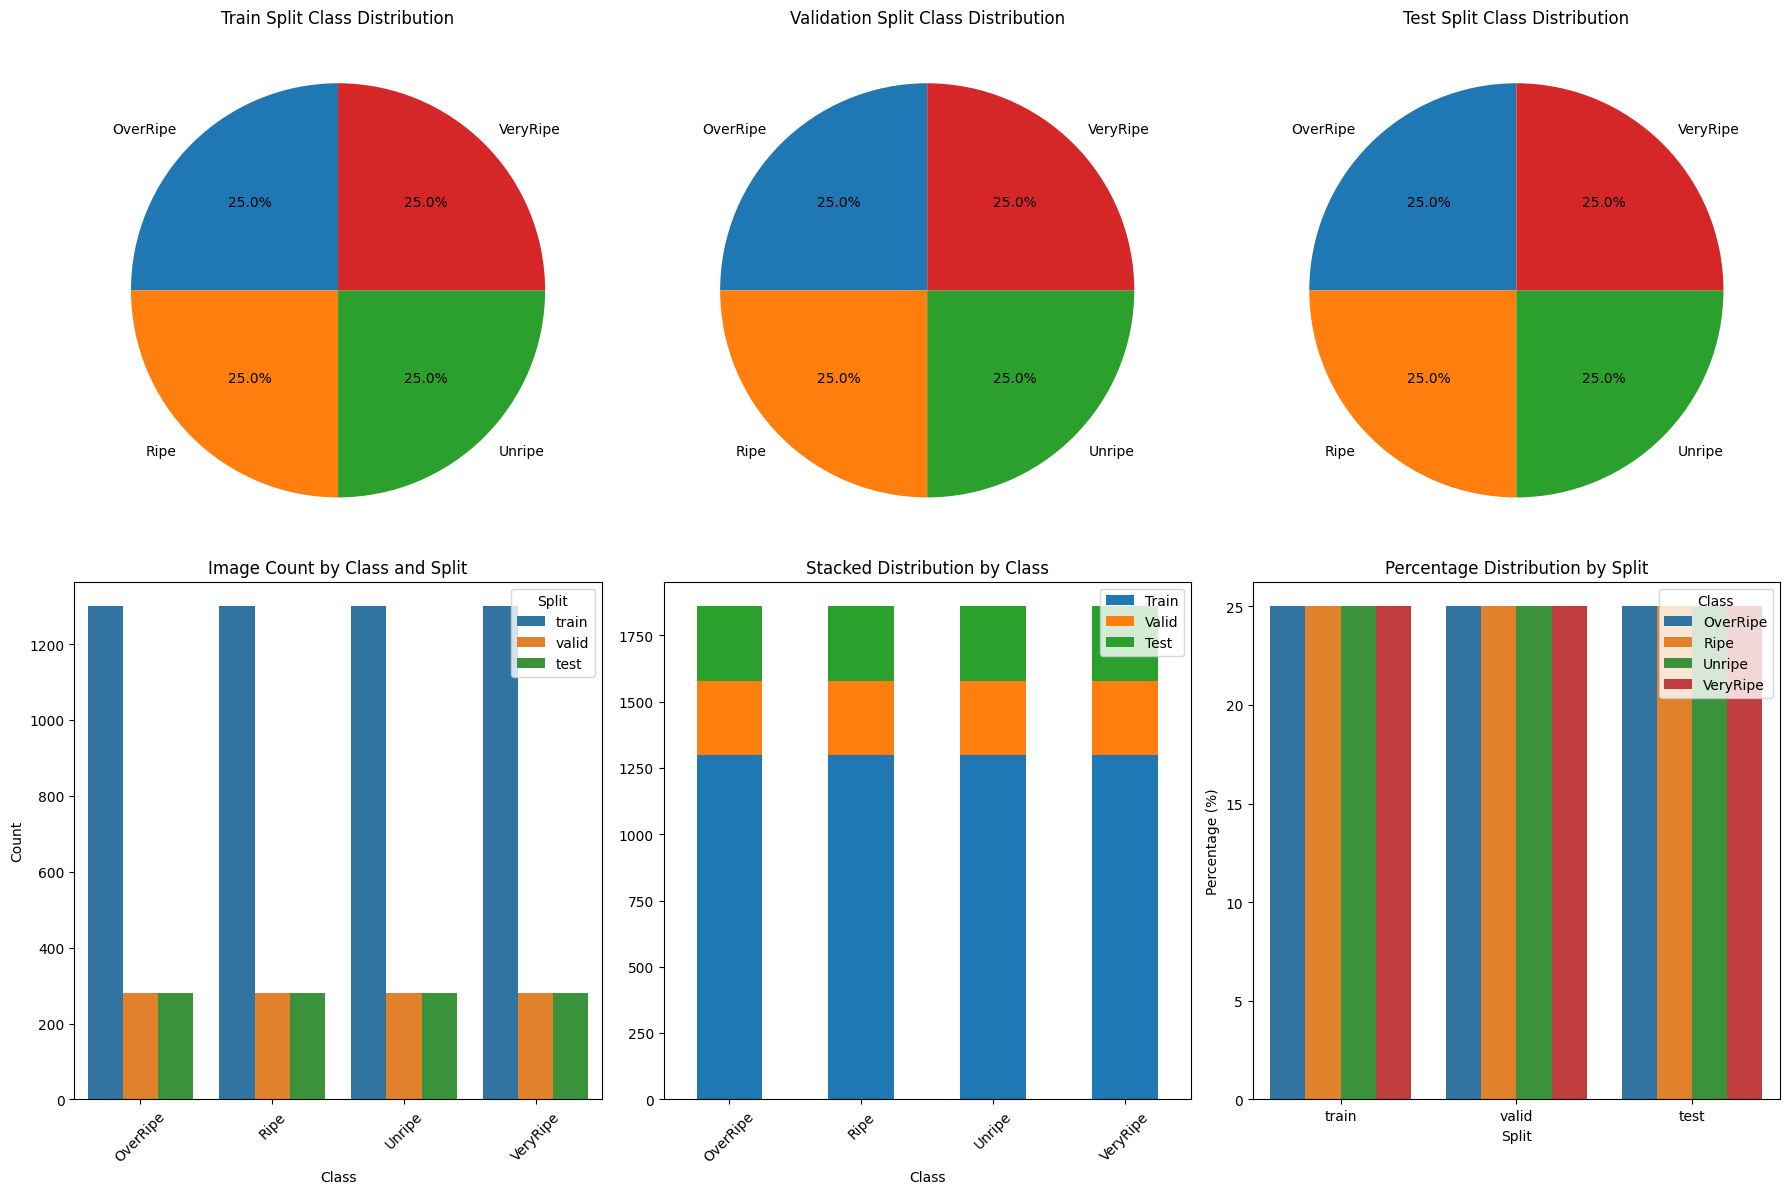


Dataset Summary:
Total images: 7440

TRAIN Split:
--------------------
OverRipe: 1300 images (25.00%)
Ripe: 1300 images (25.00%)
Unripe: 1300 images (25.00%)
VeryRipe: 1300 images (25.00%)
Total train images: 5200

VALID Split:
--------------------
OverRipe: 280 images (25.00%)
Ripe: 280 images (25.00%)
Unripe: 280 images (25.00%)
VeryRipe: 280 images (25.00%)
Total valid images: 1120

TEST Split:
--------------------
OverRipe: 280 images (25.00%)
Ripe: 280 images (25.00%)
Unripe: 280 images (25.00%)
VeryRipe: 280 images (25.00%)
Total test images: 1120


In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from google.colab import drive

def visualize_dataset(dataset_dir):
    """
    Visualize the mango dataset with various charts

    Args:
        dataset_dir: Path to the dataset directory with train/valid/test splits
    """
    # Mount Google Drive
    drive.mount('/content/drive')

    # Define class names
    classes = ['OverRipe', 'Ripe', 'Unripe', 'VeryRipe']

    # Define splits
    splits = ['train', 'valid', 'test']

    # Dictionary to store counts
    counts = {split: {cls: 0 for cls in classes} for split in splits}
    split_totals = {split: 0 for split in splits}
    total_images = 0

    # Count images in each class for each split
    for split in splits:
        split_dir = os.path.join(dataset_dir, split)

        if not os.path.exists(split_dir):
            print(f"Warning: {split_dir} not found!")
            continue

        for class_name in classes:
            class_dir = os.path.join(split_dir, class_name)

            if not os.path.exists(class_dir):
                print(f"Warning: {class_dir} not found!")
                continue

            # Count image files
            img_count = len([f for f in os.listdir(class_dir)
                            if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
            counts[split][class_name] = img_count
            split_totals[split] += img_count
            total_images += img_count

    # Create a DataFrame for easier plotting
    data = []
    for split in splits:
        for class_name in classes:
            data.append({
                'Split': split,
                'Class': class_name,
                'Count': counts[split][class_name],
                'Percentage': counts[split][class_name] / split_totals[split] * 100 if split_totals[split] > 0 else 0
            })

    df = pd.DataFrame(data)

    # Set up a larger figure size
    plt.figure(figsize=(18, 12))

    # 1. Pie charts for class distribution in each split
    plt.subplot(2, 3, 1)
    plt.pie([counts['train'][cls] for cls in classes], labels=classes, autopct='%1.1f%%', startangle=90)
    plt.title('Train Split Class Distribution')

    plt.subplot(2, 3, 2)
    plt.pie([counts['valid'][cls] for cls in classes], labels=classes, autopct='%1.1f%%', startangle=90)
    plt.title('Validation Split Class Distribution')

    plt.subplot(2, 3, 3)
    plt.pie([counts['test'][cls] for cls in classes], labels=classes, autopct='%1.1f%%', startangle=90)
    plt.title('Test Split Class Distribution')

    # 2. Bar chart for overall dataset distribution
    plt.subplot(2, 3, 4)
    sns.barplot(data=df, x='Class', y='Count', hue='Split')
    plt.title('Image Count by Class and Split')
    plt.xticks(rotation=45)
    plt.legend(title='Split')

    # 3. Stacked bar chart for class distribution across splits
    class_totals = {cls: sum(counts[split][cls] for split in splits) for cls in classes}
    df_stacked = pd.DataFrame({
        'Class': classes,
        'Total': [class_totals[cls] for cls in classes],
        'Train': [counts['train'][cls] for cls in classes],
        'Valid': [counts['valid'][cls] for cls in classes],
        'Test': [counts['test'][cls] for cls in classes]
    })

    plt.subplot(2, 3, 5)
    df_stacked.plot(x='Class', y=['Train', 'Valid', 'Test'], kind='bar', stacked=True, ax=plt.gca())
    plt.title('Stacked Distribution by Class')
    plt.xticks(rotation=45)

    # 4. Normalize bar chart (percentage)
    plt.subplot(2, 3, 6)
    sns.barplot(data=df, x='Split', y='Percentage', hue='Class')
    plt.title('Percentage Distribution by Split')
    plt.ylabel('Percentage (%)')
    plt.legend(title='Class')

    # Adjust layout
    plt.tight_layout()
    plt.savefig(os.path.join(os.path.dirname(dataset_dir), 'dataset_visualization.png'), dpi=300)
    plt.show()

    # Print summary statistics
    print("\nDataset Summary:")
    print("=" * 40)
    print(f"Total images: {total_images}")

    for split in splits:
        print(f"\n{split.upper()} Split:")
        print("-" * 20)
        for class_name in classes:
            count = counts[split][class_name]
            percentage = count / split_totals[split] * 100 if split_totals[split] > 0 else 0
            print(f"{class_name}: {count} images ({percentage:.2f}%)")
        print(f"Total {split} images: {split_totals[split]}")

# Run the visualization function
if __name__ == "__main__":
    # Path to the balanced dataset
    dataset_dir = "/content/drive/MyDrive/CS471_AI/FinalProject/MangoDataset_Balanced"

    visualize_dataset(dataset_dir)
